<a href="https://colab.research.google.com/github/JaySakarvadia/disease-prognosis-diagnoses/blob/main/Jay_Sakarvadia_ME315_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install ucimlrepo
!pip install category_encoders
!pip install catboost

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from catboost import CatBoostClassifier, CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [ ]:
#fetch dataset
support2 = fetch_ucirepo(id=880)

In [ ]:
# original data (as pandas dataframes)
X = support2.data.features
y = support2.data.targets

In [ ]:
# metadata
print(support2.metadata)

# variable information
print(support2.variables)

{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

In [ ]:
#recomended values to fill in for empty values based off Professor Frank Harrell
fill_values = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9,
    'urine': 2502
}

# impute data's missing values with the specified fill-in values
X.fillna(value=fill_values, inplace=True)
y.fillna(value=fill_values, inplace=True)

<ipython-input-43-6b607b1a5502>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(value=fill_values, inplace=True)
<ipython-input-43-6b607b1a5502>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(value=fill_values, inplace=True)


In [ ]:
# DataFrame after Imputation
data = pd.concat([X, y], axis=1)
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,7.459961,NaN,6.51,2502.0,7.0,7.0,7.000000,0,0,NaN
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,7.250000,NaN,6.51,2502.0,NaN,1.0,1.000000,1,1,<2 mo. follow-up
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,NaN,...,7.459961,NaN,6.51,2502.0,1.0,0.0,0.000000,1,0,<2 mo. follow-up
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,NaN,...,NaN,NaN,6.51,2502.0,0.0,0.0,0.000000,1,0,no(M2 and SIP pres)
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,50127.0,NaN,...,7.509766,NaN,6.51,2502.0,NaN,2.0,2.000000,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,NaN,0.0,52870.0,34329.3125,...,7.459961,188.0,21.00,2502.0,NaN,0.0,0.000000,0,0,NaN
9101,55.15399,female,Coma,Coma,1,11.0,NaN,41.0,35377.0,23558.5000,...,7.289062,190.0,49.00,0.0,NaN,0.0,0.000000,0,0,NaN
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,0.0,46564.0,31409.0156,...,7.379883,189.0,60.00,3900.0,NaN,NaN,2.525391,0,0,NaN
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,NaN,0.0,58439.0,NaN,...,7.469727,246.0,55.00,2502.0,NaN,0.0,0.000000,1,1,<2 mo. follow-up


In [ ]:
specific_column_missing = data['sfdm2'].isnull().sum()
print(f"Missing entries in 'sfdm2': {specific_column_missing}")

Missing entries in 'sfdm2': 1400


In [ ]:
specific_column_missing = data['dzgroup'].isnull().count()
print(f"Missing entries in 'dzgroup': {specific_column_missing}")

Missing entries in 'dzgroup': 9105


In [ ]:
data = data.dropna()
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
834,55.98599,male,CHF,COPD/CHF/Cirrhosis,3,18.0,>$50k,0.0,90756.0,45550.0625,...,7.500000,141.0,31.0,1875.0,0.0,0.0,0.0,1,1,<2 mo. follow-up
849,85.10297,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,$11-$25k,9.0,62841.0,21997.9062,...,7.469727,353.0,20.0,2978.0,1.0,1.0,1.0,0,0,no(M2 and SIP pres)
903,35.26599,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,12.0,$11-$25k,0.0,48956.0,23854.9062,...,7.319336,110.0,4.0,2870.0,6.0,6.0,6.0,0,0,SIP>=30
907,76.44098,male,ARF/MOSF w/Sepsis,ARF/MOSF,2,12.0,$25-$50k,0.0,23486.0,11454.5703,...,7.409180,189.0,69.0,2560.0,0.0,0.0,0.0,1,0,no(M2 and SIP pres)
938,52.51199,female,ARF/MOSF w/Sepsis,ARF/MOSF,2,12.0,>$50k,0.0,69096.0,19972.7031,...,7.359375,113.0,5.0,3400.0,0.0,3.0,3.0,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055,74.05896,female,Lung Cancer,Cancer,1,11.0,$11-$25k,0.0,13262.0,8684.1641,...,7.429688,76.0,39.0,2625.0,5.0,7.0,7.0,1,0,adl>=4 (>=5 if sur)
9066,69.36597,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,12.0,$25-$50k,0.0,6555.0,4531.9766,...,7.449219,149.0,30.0,4375.0,0.0,0.0,0.0,0,0,no(M2 and SIP pres)
9070,77.33295,female,Lung Cancer,Cancer,2,12.0,$11-$25k,0.0,1212.0,805.0625,...,7.419922,165.0,18.0,1025.0,0.0,0.0,0.0,1,0,<2 mo. follow-up
9081,54.05298,male,Lung Cancer,Cancer,1,12.0,$25-$50k,0.0,7228.0,4629.1406,...,7.479492,121.0,47.0,3100.0,0.0,0.0,0.0,1,0,no(M2 and SIP pres)


In [ ]:
#all categories of diseases
disease_group_categories = pd.DataFrame(data['dzgroup'].unique())
disease_group_categories


,0
0,CHF
1,ARF/MOSF w/Sepsis
2,Lung Cancer
3,MOSF w/Malig
4,Colon Cancer
5,COPD
6,Cirrhosis
7,Coma


In [ ]:
type(data['dzgroup'])

pandas.core.series.Series

In [ ]:
disease_group_counts = data['dzgroup'].value_counts()
print(disease_group_counts)

dzgroup
ARF/MOSF w/Sepsis    135
CHF                  121
COPD                  95
Lung Cancer           77
MOSF w/Malig          48
Colon Cancer          39
Cirrhosis             31
Coma                   3
Name: count, dtype: int64


<ipython-input-51-7c8c3f83e219>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='dzgroup', y='Count', data=df, palette='deep')
<ipython-input-51-7c8c3f83e219>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(['' for _ in range(len(df['dzgroup']))])


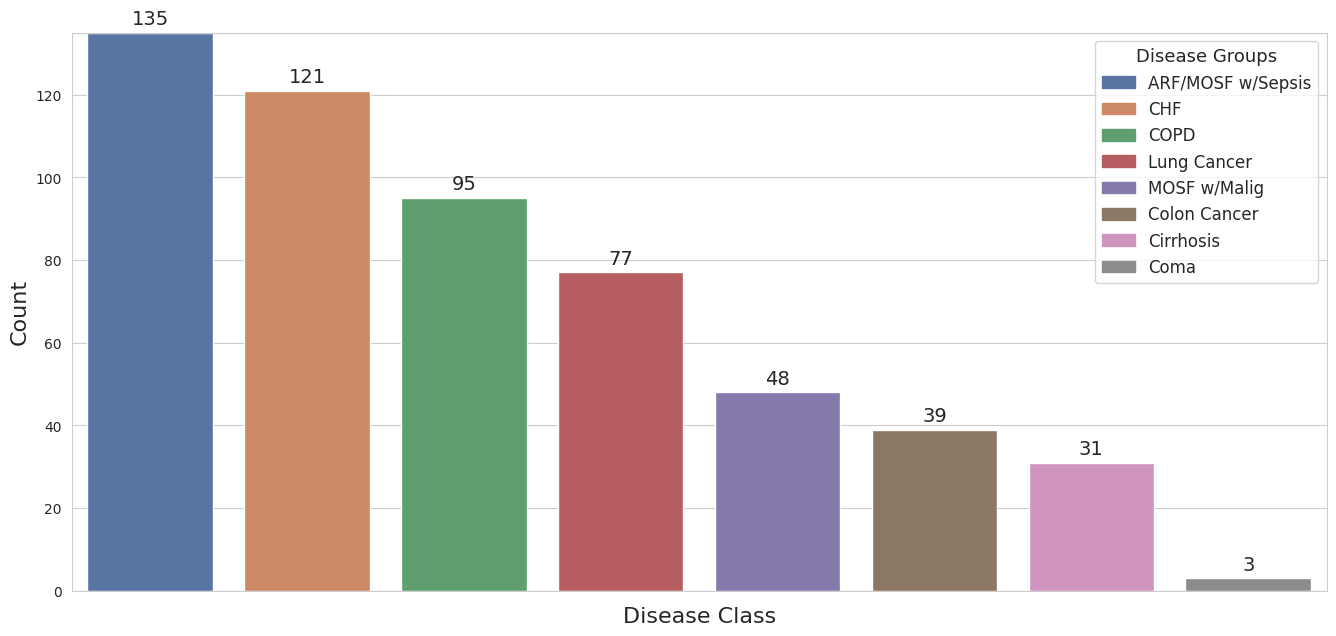

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
graph_data = {
    'dzgroup': [
        'ARF/MOSF w/Sepsis', 'CHF', 'COPD', 'Lung Cancer',
        'MOSF w/Malig', 'Colon Cancer', 'Cirrhosis', 'Coma'
    ],
    'Count': [135, 121, 95, 77, 48, 39, 31, 3]
}

# Create DataFrame
df = pd.DataFrame(graph_data)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='dzgroup', y='Count', data=df, palette='deep')

# Remove x-axis labels
bar_plot.set_xticklabels(['' for _ in range(len(df['dzgroup']))])

# Adjust the y-axis limits to add more space at the top
max_count = df['Count'].max()
bar_plot.set_ylim(0, max_count)  # Add 20 to the maximum count to add space at the top

# Add value labels on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 10),  # Moved the text a bit higher
                      textcoords = 'offset points',
                      fontsize=14)

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=bar_plot.patches[i].get_facecolor()) for i in range(len(df))]
labels = df['dzgroup'].tolist()
plt.legend(handles, labels, loc='upper right', fontsize=12, title='Disease Groups', title_fontsize='13')

# Add labels and title
bar_plot.set_xlabel('Disease Class', fontsize=16)
bar_plot.set_ylabel('Count', fontsize=16)

# Adjust layout to ensure everything fits well
plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
X = data.drop('dzgroup', axis=1)
y = data['dzgroup']

X.shape

(549, 44)

In [ ]:
X.dtypes

age         float64
sex          object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
death         int64
hospdead      int64
sfdm2        object
dtype: object

# CatBoost

In [ ]:
#standardized version of CatBoost test

# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Label encode target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardized hyperparameters
learning_rate = 0.01
n_estimators = 500
max_depth = 4
l2_leaf_reg = 0  # Default value, adjust as needed
early_stopping_rounds = 100

# Initialize CatBoostClassifier with standardized hyperparameters
catboost_clf = CatBoostClassifier(
    iterations=n_estimators,
    learning_rate=learning_rate,
    depth=max_depth,
    l2_leaf_reg=l2_leaf_reg,
    cat_features=categorical_cols,
    verbose=100,
    auto_class_weights='Balanced'
)

# Train CatBoostClassifier
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=early_stopping_rounds)

# Make predictions
y_pred = catboost_clf.predict(X_test)

# Convert the encoded labels back to original class names for evaluation
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'CatBoost Classifier Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

0:	learn: 2.0649396	test: 2.0600126	best: 2.0600126 (0)	total: 61.7ms	remaining: 30.8s
100:	learn: 1.0446101	test: 1.3276802	best: 1.3272915 (99)	total: 5.27s	remaining: 20.8s
200:	learn: 0.7727002	test: 1.1657864	best: 1.1622339 (198)	total: 10.7s	remaining: 15.9s
300:	learn: 0.6420829	test: 1.1926507	best: 1.1444254 (253)	total: 17.9s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.144425377
bestIteration = 253

Shrink model to first 254 iterations.
CatBoost Classifier Accuracy: 0.6363636363636364
Classification Report:
                   precision    recall  f1-score   support

ARF/MOSF w/Sepsis       1.00      0.85      0.92        27
              CHF       0.45      0.45      0.45        22
             COPD       0.32      0.38      0.34        16
        Cirrhosis       0.50      0.29      0.36         7
     Colon Cancer       0.50      0.78      0.61         9
             Coma       1.00      1.00      1.00         2
      Lung Cancer   

The warning "UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples" means that your CatBoost model is not predicting any samples for certain classes (disease categories in your case).

Here are some steps you can take to address this issue:

Check Class Imbalance: Examine if your dataset has a significant class imbalance, where some disease categories have very few samples compared to others. You can use:

# XGBoost

In [ ]:
#standardized version of XGBoost test

# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Label encode target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = dict(pd.Series(y_train).value_counts(normalize=True))
weights = [class_weights[i] for i in y_train]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest = xgb.DMatrix(X_test, label=y_test)

# Standardized hyperparameters
learning_rate = 0.01
n_estimators = 1000
max_depth = 4
reg_lambda = 0  # L2 regularization
early_stopping_rounds = 100

# Define parameters
params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'num_class': len(label_encoder.classes_),  # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metric
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'lambda': reg_lambda
}

# Train the model
xgb_clf = xgb.train(params, dtrain, num_boost_round=n_estimators, evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=early_stopping_rounds, verbose_eval=100)

# Make predictions
y_pred_proba = xgb_clf.predict(dtest)
y_pred = y_pred_proba.argmax(axis=1)  # Choose the class with the highest probability

# Convert the encoded labels back to original class names for evaluation
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Classifier Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

[0]	train-mlogloss:2.05338	eval-mlogloss:2.05891
[100]	train-mlogloss:0.94239	eval-mlogloss:1.22691
[200]	train-mlogloss:0.59378	eval-mlogloss:0.98999
[300]	train-mlogloss:0.42409	eval-mlogloss:0.91503
[400]	train-mlogloss:0.32119	eval-mlogloss:0.88789
[500]	train-mlogloss:0.26452	eval-mlogloss:0.88467
[534]	train-mlogloss:0.25150	eval-mlogloss:0.88447
XGBoost Classifier Accuracy: 0.6818181818181818
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        27
           1       0.50      0.64      0.56        22
           2       0.47      0.50      0.48        16
           3       0.00      0.00      0.00         7
           4       0.80      0.44      0.57         9
           5       0.00      0.00      0.00         2
           6       0.73      1.00      0.84        16
           7       1.00      0.55      0.71        11

    accuracy                           0.68       110
   macro avg       0.54      0.5

# LightGBM

In [ ]:
#standardized version of LightGBM test
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Label encode target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardized hyperparameters
learning_rate = 0.01
num_boost_round = 500
max_depth = 4
num_leaves = 31
reg_lambda = 0  # L2 regularization
early_stopping_rounds = 100

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_cols, reference=train_data)

# Define parameters
params = {
    'objective': 'multiclass',  # Multi-class classification
    'num_class': len(label_encoder.classes_),  # Number of classes
    'metric': 'multi_logloss',  # Evaluation metric
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'num_leaves': num_leaves,  # You can adjust this based on max_depth
    'feature_fraction': 0.9,
    'verbose': -1,
    'early_stopping_rounds': early_stopping_rounds,
    'is_unbalance': True,  # Handle class imbalance
    'lambda_l2': reg_lambda

}

# Train the model
lgbm_clf = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[train_data, test_data])

# Make predictions
y_pred_proba = lgbm_clf.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)  # Choose the class with the highest probability

# Convert the encoded labels back to original class names for evaluation
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'LightGBM Classifier Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

LightGBM Classifier Accuracy: 0.7
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        27
           1       0.50      0.50      0.50        22
           2       0.36      0.50      0.42        16
           3       1.00      0.14      0.25         7
           4       0.80      0.89      0.84         9
           5       0.00      0.00      0.00         2
           6       0.88      0.94      0.91        16
           7       1.00      0.64      0.78        11

    accuracy                           0.70       110
   macro avg       0.68      0.58      0.58       110
weighted avg       0.72      0.70      0.68       110



For all models, they perform better without l2_regularization

In [ ]:
# #Best LightGBM Parameters (Random Search): {'num_leaves': 31, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}

# lgbm_param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [4, 6, 8],
#     'num_leaves': [15, 31, 63],
#     'n_estimators': [100, 500, 1000],
# }

# # Initialize the LGBMClassifier
# lgbm_clf = lgb.LGBMClassifier(objective='multiclass', num_class=len(label_encoder.classes_), verbose=1) # Initialize the classifier

# # Random Search with verbosity
# random_search_lgbm = RandomizedSearchCV(lgbm_clf, param_distributions=lgbm_param_grid, n_iter=50, cv=3, scoring='accuracy', verbose=0, n_jobs=-1, random_state=42)
# random_search_lgbm.fit(X_train, y_train)

# # Print best parameters
# best_params_lgb = random_search_lgbm.best_params_
# print(f"Best LightGBM Parameters (Random Search): {best_params_lgb}")

# # Train and evaluate the model with best parameters
# lgb_clf_best = lgb.LGBMClassifier(**best_params_lgb, objective='multiclass', num_class=len(label_encoder.classes_), verbose=0)
# lgb_clf_best.fit(X_train, y_train)
# y_pred_best = lgb_clf_best.predict(X_test)
# improved_accuracy = accuracy_score(y_test, y_pred_best)
# print(f'Improved LightGBM Classifier Accuracy: {improved_accuracy}')
# print('Classification Report:')
# print(classification_report(y_test, y_pred_best, target_names=[str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]))

RandomForestsClassifier

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Label encode target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_clf = RandomForestClassifier(class_weight='balanced')

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Classifier Accuracy: {accuracy}')
print('Classification Report:')
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

Random Forest Classifier Accuracy: 0.6727272727272727
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        27
           1       0.52      0.77      0.62        22
           2       0.43      0.38      0.40        16
           3       0.00      0.00      0.00         7
           4       0.80      0.44      0.57         9
           5       0.00      0.00      0.00         2
           6       0.79      0.94      0.86        16
           7       0.83      0.45      0.59        11

    accuracy                           0.67       110
   macro avg       0.52      0.50      0.49       110
weighted avg       0.63      0.67      0.63       110



Logistic Regression

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize LogisticRegression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Classifier Accuracy: {accuracy}')
print('Classification Report:')
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

Logistic Regression Classifier Accuracy: 0.7181818181818181
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.62      0.59      0.60        22
           2       0.33      0.38      0.35        16
           3       1.00      0.71      0.83         7
           4       0.62      0.89      0.73         9
           5       0.00      0.00      0.00         2
           6       0.93      0.81      0.87        16
           7       0.71      0.91      0.80        11

    accuracy                           0.72       110
   macro avg       0.65      0.65      0.64       110
weighted avg       0.73      0.72      0.72       110



Logistic Regression Classifier Accuracy: 0.7181818181818181
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.62      0.59      0.60        22
           2       0.33      0.38      0.35        16
           3       1.00      0.71      0.83         7
           4       0.62      0.89      0.73         9
           5       0.00      0.00      0.00         2
           6       0.93      0.81      0.87        16
           7       0.71      0.91      0.80        11

    accuracy                           0.72       110
   macro avg       0.65      0.65      0.64       110
weighted avg       0.73      0.72      0.72       110



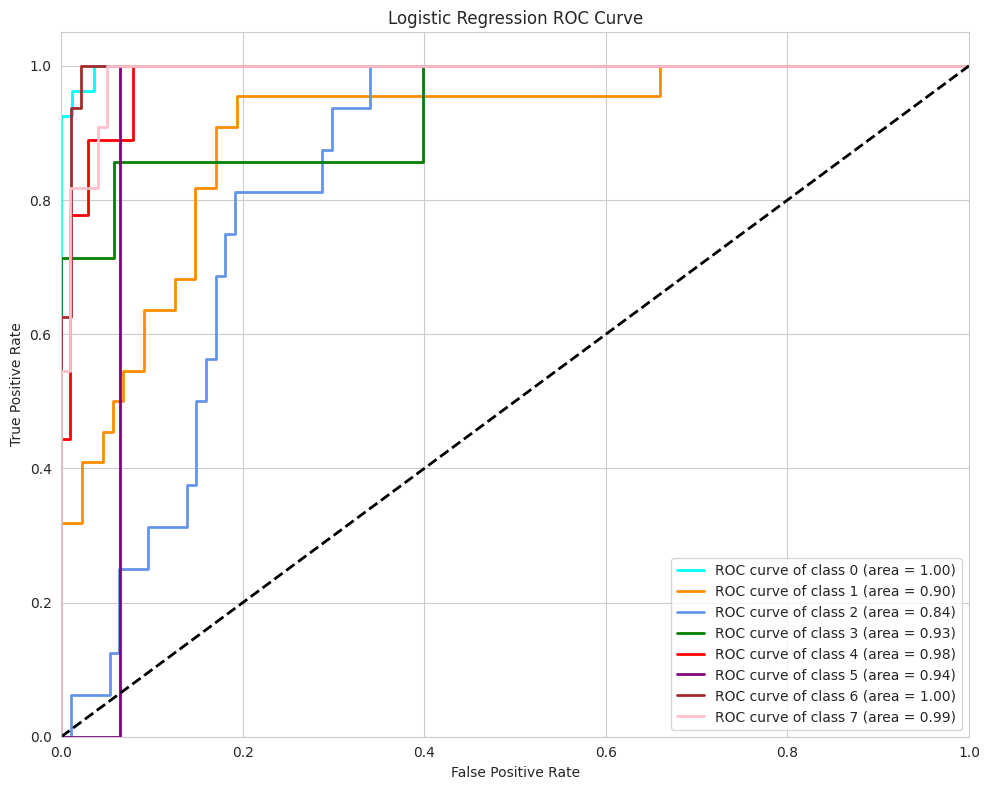

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Label encode target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize LogisticRegression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Classifier Accuracy: {accuracy}')
print('Classification Report:')
target_names = [str(cls) for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))]
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Regression


The 'sfdm2' serves as a measure of functional disability at month 2, incorporating information from questionnaires and correlations with other columns. Due to it is a continuous variable, a regression task will be designed. The values on the 1-5 scale help characterize the severity of functional disability, with 5 representing the highest severity.The meaning of its values is:


- 1: Indicates "no (Month 2 and SIP pres)" - suggesting no functional disability at month 2 and the presence of SIP.
- 2: Indicates "adl>=4 (>=5 if sur)" - suggesting a level of functional disability based on ADL scores.
- 3: Indicates "SIP>=30" - suggesting functional disability based on a SIP score of 30 or more.
- 4: Indicates "Coma or Intub" - suggesting severe disability due to coma or intubation.


In [ ]:
#all categories of diseases
lvl_of_functionality = pd.DataFrame(data['sfdm2'].unique())
lvl_of_functionality

,0
0,<2 mo. follow-up
1,no(M2 and SIP pres)
2,SIP>=30
3,adl>=4 (>=5 if sur)


In [ ]:
type(data['sfdm2'])

pandas.core.series.Series

<ipython-input-63-76e78c95dc78>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='sfdm2', y='Count', data=df, palette='deep')


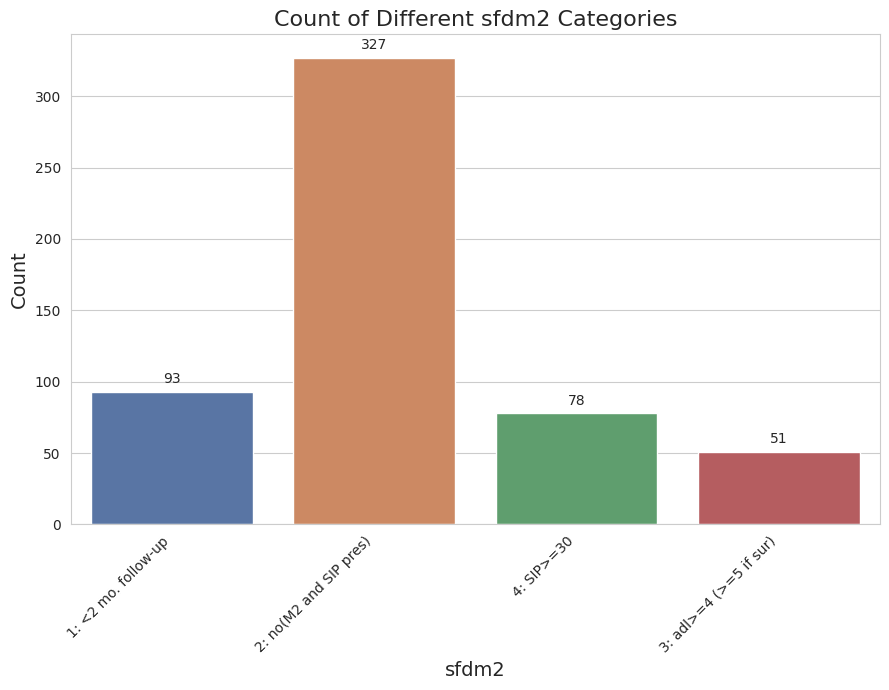

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
graph_data = {
    'sfdm2': [
        '1: <2 mo. follow-up','2: no(M2 and SIP pres)' , '4: SIP>=30', '3: adl>=4 (>=5 if sur)'
    ],
    'Count': [93, 327, 78, 51]
}

# Create DataFrame
df = pd.DataFrame(graph_data)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(9, 7))
bar_plot = sns.barplot(x='sfdm2', y='Count', data=df, palette='deep')

# Add labels and title
bar_plot.set_xlabel('sfdm2', fontsize=14)
bar_plot.set_ylabel('Count', fontsize=14)
bar_plot.set_title('Count of Different sfdm2 Categories', fontsize=16)

# Rotate x-tick labels
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Define the target variable and its numeric representation
target_variable = 'sfdm2'
target_mapping = {
    '<2 mo. follow-up': 1,
    'no(M2 and SIP pres)': 2,
    'adl>=4 (>=5 if sur)': 3,
    'SIP>=30': 4,
    'Coma or Intub': 5
}

# Convert the target variable to numeric
data['sfdm2'] = data[target_variable].map(target_mapping)

# Display the percentage values
print('Percentage values:', data['sfdm2'].value_counts(normalize=True) * 100)

Percentage values: sfdm2
2    59.562842
1    16.939891
4    14.207650
3     9.289617
Name: proportion, dtype: float64


<ipython-input-64-d0b0e62f266c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sfdm2'] = data[target_variable].map(target_mapping)


In [ ]:
X = data.drop('sfdm2', axis=1)
y = data['sfdm2']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CatBoostRegressor

In [ ]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
model = CatBoostRegressor(cat_features=categorical_cols)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

Learning rate set to 0.035949
0:	learn: 0.8856989	total: 8.32ms	remaining: 8.31s
1:	learn: 0.8826469	total: 19.4ms	remaining: 9.68s
2:	learn: 0.8784067	total: 31ms	remaining: 10.3s
3:	learn: 0.8737907	total: 44.7ms	remaining: 11.1s
4:	learn: 0.8713617	total: 55.5ms	remaining: 11.1s
5:	learn: 0.8681767	total: 66.1ms	remaining: 10.9s
6:	learn: 0.8635100	total: 75.7ms	remaining: 10.7s
7:	learn: 0.8605025	total: 86.1ms	remaining: 10.7s
8:	learn: 0.8579860	total: 95.6ms	remaining: 10.5s
9:	learn: 0.8550704	total: 106ms	remaining: 10.5s
10:	learn: 0.8532216	total: 117ms	remaining: 10.5s
11:	learn: 0.8505067	total: 128ms	remaining: 10.6s
12:	learn: 0.8479759	total: 141ms	remaining: 10.7s
13:	learn: 0.8458930	total: 151ms	remaining: 10.6s
14:	learn: 0.8436322	total: 155ms	remaining: 10.2s
15:	learn: 0.8409936	total: 166ms	remaining: 10.2s
16:	learn: 0.8390984	total: 173ms	remaining: 9.99s
17:	learn: 0.8370276	total: 183ms	remaining: 10s
18:	learn: 0.8347879	total: 199ms	remaining: 10.3s
19:	le

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize LinearRegression
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lin_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.6847114644621022


In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize Ridge Regression
ridge_reg = Ridge()

# Train the model
ridge_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ridge_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Ridge Regression Mean Squared Error (MSE): {mse}')

Ridge Regression Mean Squared Error (MSE): 0.6802741706546279


In [ ]:
lasso_reg = Lasso()

# Train the model
lasso_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lasso_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Lasso Regression Mean Squared Error (MSE): {mse}')

Lasso Regression Mean Squared Error (MSE): 0.7750095639905259


In [ ]:

# Initialize Elastic Net Regression
elastic_net_reg = ElasticNet()

# Train the model
elastic_net_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = elastic_net_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Elastic Net Regression Mean Squared Error (MSE): {mse}')

Elastic Net Regression Mean Squared Error (MSE): 0.7750095639905259


XGBoostRegressor

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_reg = xgb.XGBRegressor()

# Train the model
xgb_reg.fit(X_train, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.7637472229922376


LightGBM

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM Regressor
lgbm_reg = lgb.LGBMRegressor(objective='regression')

# Train the model
lgbm_reg.fit(X_train, y_train, categorical_feature=categorical_cols)

# Make predictions
y_pred = lgbm_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 439, number of used features: 43
[LightGBM] [Info] Start training from score 2.195900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

RandomForestsRegressor

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForest Regressor
rf_reg = RandomForestRegressor()

# Train the model
rf_reg.fit(X_train, y_train)

# Make predictions
y_pred = rf_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.6396590909090909


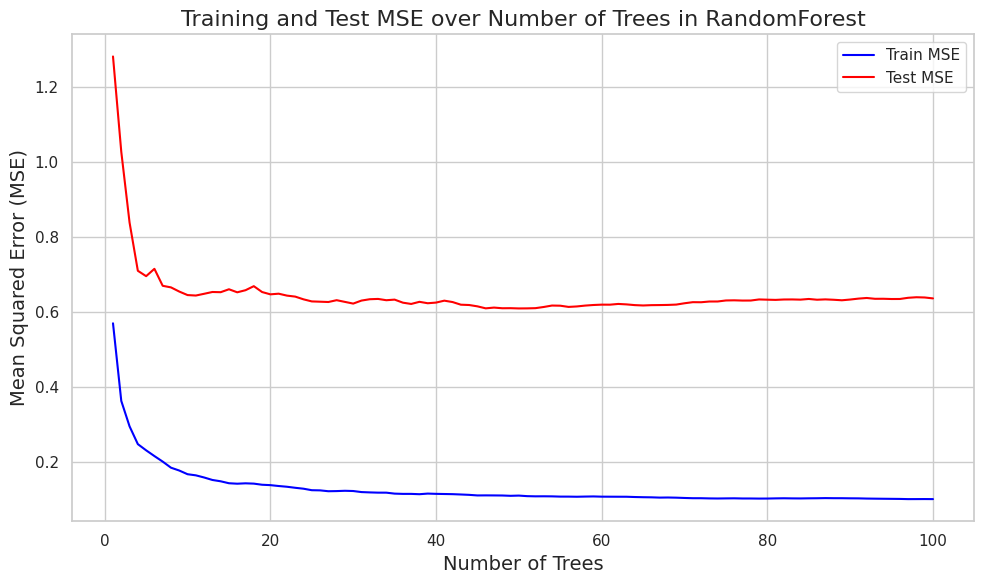

In [ ]:
# Identify and encode categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize parameters for RandomForest Regressor
n_estimators = 100  # Number of trees in the forest
train_errors = []
test_errors = []

# Initialize RandomForest Regressor
rf_reg = RandomForestRegressor(n_estimators=1, warm_start=True)

# Iteratively train the RandomForest and record test error
for i in range(1, n_estimators + 1):
    rf_reg.set_params(n_estimators=i)
    rf_reg.fit(X_train, y_train)

    # Predict and calculate mean squared error
    y_train_pred = rf_reg.predict(X_train)
    y_test_pred = rf_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Create a DataFrame for plotting
errors_df = pd.DataFrame({
    'Number of Trees': range(1, n_estimators + 1),
    'Train MSE': train_errors,
    'Test MSE': test_errors
})

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot training and test errors over number of trees
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Trees', y='Train MSE', data=errors_df, label='Train MSE', color='blue')
sns.lineplot(x='Number of Trees', y='Test MSE', data=errors_df, label='Test MSE', color='red')
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Training and Test MSE over Number of Trees in RandomForest', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostRegressor

# # Define the parameter grid for each model
# param_grid_rf = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# param_grid_xgb = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [1, 1.5, 2]
# }

# param_grid_lgbm = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [-1, 10, 20, 30],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [31, 40, 50],
#     'min_child_samples': [20, 30, 40],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [0, 1, 1.5]
# }

# param_grid_catboost = {
#     'iterations': [100, 200, 500],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'l2_leaf_reg': [3, 5, 7],
#     'subsample': [0.8, 0.9, 1.0]
# }

# # Initialize the models
# rf = RandomForestRegressor()
# xgb_reg = xgb.XGBRegressor()
# lgbm_reg = lgb.LGBMRegressor()
# catboost_reg = CatBoostRegressor(verbose=0)

# # Perform Randomized Search
# random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=50, cv=3, verbose=10, n_jobs=-1, random_state=42)
# random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_grid_xgb, n_iter=50, cv=3, verbose=10, n_jobs=-1, random_state=42)
# random_search_lgbm = RandomizedSearchCV(lgbm_reg, param_distributions=param_grid_lgbm, n_iter=50, cv=3, verbose=10, n_jobs=-1, random_state=42)
# random_search_catboost = RandomizedSearchCV(catboost_reg, param_distributions=param_grid_catboost, n_iter=50, cv=3, verbose=10, n_jobs=-1, random_state=42)

# # Fit the models
# random_search_rf.fit(X_train, y_train)
# random_search_xgb.fit(X_train, y_train)
# random_search_lgbm.fit(X_train, y_train)
# random_search_catboost.fit(X_train, y_train)

# # Get the best parameters and print them
# print(f"Best parameters for Random Forest: {random_search_rf.best_params_}")
# print(f"Best parameters for XGBoost: {random_search_xgb.best_params_}")
# print(f"Best parameters for LightGBM: {random_search_lgbm.best_params_}")
# print(f"Best parameters for CatBoost: {random_search_catboost.best_params_}")

# # Evaluate the best models
# best_rf = random_search_rf.best_estimator_
# best_xgb = random_search_xgb.best_estimator_
# best_lgbm = random_search_lgbm.best_estimator_
# best_catboost = random_search_catboost.best_estimator_

# # Make predictions and evaluate the models
# for model, name in zip([best_rf, best_xgb, best_lgbm, best_catboost], ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']):
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     print(f'{name} Mean Squared Error (MSE): {mse}')


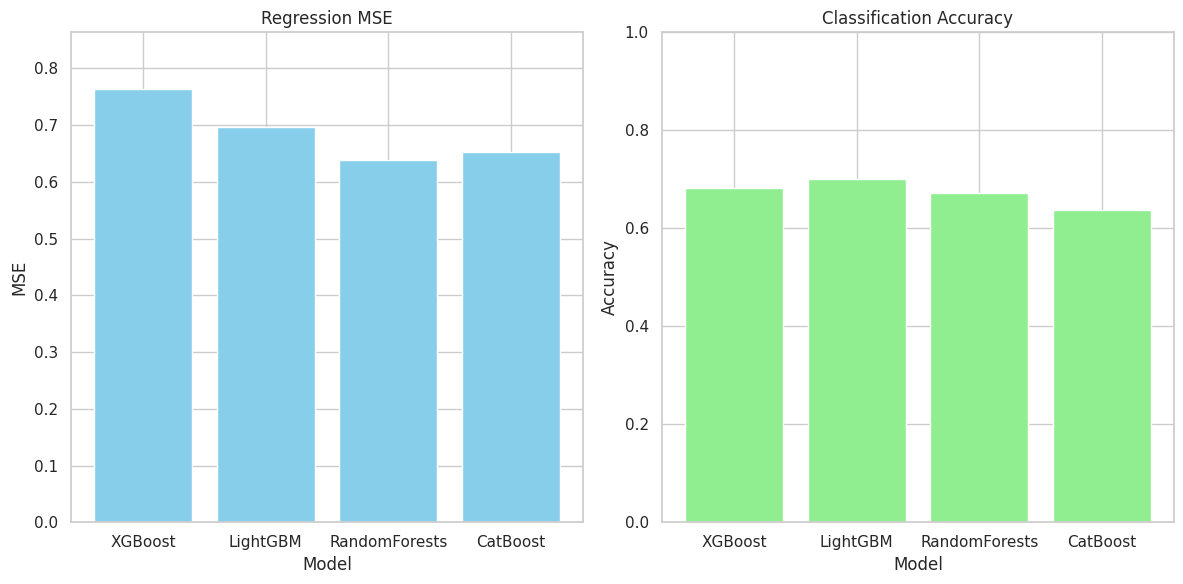

In [ ]:
# Data
models = ['XGBoost', 'LightGBM', 'RandomForests', 'CatBoost']
mse = [0.763747223, 0.6967533, 0.638993636, 0.652587158]
accuracy = [0.681818182, 0.7, 0.672727273, 0.636363636]

# Create bar chart for MSE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, mse, color='skyblue')
plt.title('Regression MSE')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.ylim(0, max(mse) + 0.1)

# Create bar chart for Accuracy
plt.subplot(1, 2, 2)
plt.bar(models, accuracy, color='lightgreen')
plt.title('Classification Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
